# Data Exploration & Research

## Default imports

In [4]:
import os
import sys
import cv2
import numpy as np
import pandas as pd
import sklearn
import requests
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

%matplotlib inline

## Video Image Split

In [7]:
!ls ./poc_dataset/images

VIRAT_S_000002_fr_0.2  VIRAT_S_000002_fr_2.0


In [55]:
def filter_file_extension(filename):
    
    file_extension = 'mp4'
    
    if file_extension in filename:
        return True
    else:
        return False

def get_videos_from_folder(path):
    
    all_items = os.listdir(path)
    only_videos = [video_name for video_name in filter(filter_file_extension, all_items)]
    video_filenames = [video_name.split('.')[0] for video_name in only_videos]
    videos_file_paths = [os.path.join(path, video_fp) for video_fp in only_videos]
    
    return videos_file_paths, video_filenames

In [57]:
video_file_paths, video_filenames = get_videos_from_folder('./poc_dataset/')

In [58]:
def get_frame(sec, video_object):
    '''
        Based on the given sec, extract the resulting image from the video_object.
    '''
    video_object.set(cv2.CAP_PROP_POS_MSEC, sec*1000)
    success, image = video_object.read()
    return success, image
    

def write_images_from_video(video_path, video_filename, frame_rate):
    '''
        Splits the video by the frame_rate, shown in the video_path variable into different frames,
        then writes the resulting images in a folder with the  video's filename.
        Creates the folder if it exits.
    
    '''
    video_object = cv2.VideoCapture(video_path)
    sec = 0
    count = 0
    frame_rate = 1 / frame_rate # looking at the actual time from second to the next
    success = 1
    
    while success:
        
        success, image = get_frame(sec, video_object)
        
        # create the folder if not exists
        video_file_name = f'{video_filename}_fr_{frame_rate}'
        folder_path = f'./poc_dataset/images/{video_file_name}'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        
        # write the image
        cv2.imwrite(os.path.join(folder_path, f'{video_filename}_frame_{np.round(count,2)}.jpg'), image)
        
        sec = sec + frame_rate
        count += 1
    
    print(f'File {video_filename} processed.')

In [59]:
write_images_from_video(video_file_paths[0], video_filenames[0], 0.5)

File VIRAT_S_000002 processed.


## Display a sample image

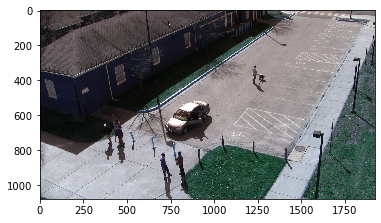

In [19]:
# choose a random image
folder = './poc_dataset/images/VIRAT_S_000002_fr_2.0/'
dirlist = np.array(os.listdir(folder))
choice = np.random.choice(dirlist)
image_path = os.path.join(folder, choice)

show_image(image_path)

We can see a number of people captured in a webcam from an angle, which is the expectation.

## Utils
Various helper functions that are used in general. It will be used throughout the notebook

In [7]:
def load_csv_datasets(path):
    files = os.listdir(path)
    
    data = {}
    for file in files:
        filename = file.split('.')[0]
        filepath = os.path.join(path, file)
        data[filename] = pd.read_csv(filepath)
    
    return data

In [10]:
def show_image(path):
    image = cv2.imread(path)
    plt.imshow(image)

## Research

### 1. People Counting with Object Detection Methods

[Reference](https://machinelearningmastery.com/object-recognition-with-deep-learning/?fbclid=IwAR3QHzwV3iteB2tE7EJo3GkNTT_v7loLqHtCqYuH5nopySIkzvTmHiUa-H0)

#### 1.1 Faster R-CNN
* [Reference of Faster R-CNN](https://arxiv.org/pdf/1506.01497.pdf)  
* [Reference of implementation](https://towardsdatascience.com/faster-r-cnn-object-detection-implemented-by-keras-for-custom-data-from-googles-open-images-125f62b9141a)
* [Reference Jupyter Notebook for the implementation](https://github.com/RockyXu66/Faster_RCNN_for_Open_Images_Dataset_Keras/blob/master/frcnn_train_vgg.ipynb)

#### 1.1.1 Implemented Faster RCNN
Faster RCNN is the third itteration of the RCNN implementation, with the advantage of being faster. This is due to implementing a RPN (region proposal network) instead of using SS (selective search). More details can be found in the following papers:
* [Rich feature hierarchies for accurate object detection and semantic segmentation](https://arxiv.org/abs/1311.2524)
* [Fast R-CNN](https://arxiv.org/abs/1504.08083)
* [Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks](https://arxiv.org/abs/1506.01497)

### 1.2. YOLO
The YOLO (You Only Look Once) Algorithm for Object Detection. You can find more details by reading the paper:
* [YOLOv3: An Incremental Improvement](https://pjreddie.com/media/files/papers/YOLOv3.pdf).  
For the purpose of the PoC a pretrained model will be used, or more specificaly [keras-yolo3](https://github.com/experiencor/keras-yolo3). 

## 2. Problems with scaling the solution
The problem is with the previous methods is that when scaling the solution for crowds (or large quantities of people in the picture) occlusion and clutter will play a large role and the model will not be able to make an accurate prediction. Thus an [alternative approach](https://arxiv.org/pdf/1906.09707.pdf) will be used by using density maps.